# Классификация изображений с использованием tf.keras

В этом CoLab вы будете классифицировать изображения цветов. Вы будете разрабатывать классификатор изображений с использованием `tf.keras.Sequential`, а данные загружать с использованием `ImageDataGenerator`.

# Импортирование пакетов

Давайте начнем с импортирования необходимых пакетов. `os` пакет нужен нам для чтения файлов и структуры директорий, `numpy` нужен нам для преобразования python-списков в numpy-массивы для выполнения матричных операций и, в завершение, нам понадобится `matplotlib.pyplot` для отрисовки графиков и отображения исходных и преобразованных изображений.

In [138]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

### TODO: импортируем TensorFlow и Keras-слои

В приведённой ниже области для исходного кода импортируйте TensorFlow как `tf` и Keras-слои с моделями, которые вы будете использовать для построения свёрточной нейронной сети. Так же, импортируйте `ImageDataGenerator`-класс из Keras для работы с изображениями и расширения исходного набора данных.

In [139]:
# импорт пакетов
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Загрузка данных

Начать разработку нашего классификатора изображений нужно с загрузки набора данных с которым мы будем работать - цветочный набор данных. Первым делом необходимо загрузить архив с набором данных и сохранить его во временной директории.

Загруженный архив необходимо разархивировать.

In [140]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

Набор данных, который мы загрузили архивом, содержит 5 типов цветов:
1. Розы
2. Маргаритки
3. Одуванчики
4. Подсолнухи
5. Тюльпаны

Создадим метки для каждого из этих пяти классов:

In [141]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Набор данных, который мы загрузили, имеет следующую структуру:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Как вы уже обратили внимание в структуре загруженного набора данных отсутствуют директории с обучающим набором данных и валидационным. Таким образом создание этих двух наборов данных будет лежать на наших плечах. Давайте напишем код, который будет это делать.

Код ниже создаёт 2 директории `train` и `val` в каждой из которых будет 5 под-директорий (одна на каждый тип изображения). После этого мы переместим изображения в эти директории таким образом, чтобы 80% изображений попадало в обучающий набор данных, а остальные 20% попадали в валидационный набор данных. Итоговая структура будет выглядеть следующим образом:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]   
</pre>

Так как мы не удаляем исходные директории, то они останутся у нас, но будут пустыми. Код ниже так же выведет на экран количество изображений по каждому типу цветка.

In [142]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} изображений".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]
  
  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))
    
  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 изображений
daisy: 633 изображений
dandelion: 898 изображений
sunflowers: 699 изображений
tulips: 799 изображений


Для удобства вынесем ссылки на директории каждого набора данных в отдельные переменные:

In [143]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Расширение данных

Переобучение, в основном, происходит тогда, когда у нас маленький обучающий набор данных. Один из способов устранить эту проблему - расширение данных (т.н. augmentation) до нужного количества обучающих примеров. Расширение данных представляет собой процесс применения произвольных трансформации к исходным данным и добавление полученных изменённых данных в первоначальный обучающий набор. Цель заключается в том, чтобы сгенерировать реалистичные изображения, которые модель больше никогда не увидит в последующем - ни в валидационном наборе данных, ни в тестовом. Такой подход позволяет модели лучше обобщать и извлекать различные признаки.

В **tf.keras** мы можем это реализовать с использованием класса, который раньше нами применялся для генерации обучающего набора данных кошек и собак - **ImageDataGenerator**. Мы просто передаём конструктору класса набор различных значений нужных нам параметров и обо всём остальном он позаботится сам. 

## Экспериментируйте с различными преобразованиями изображений

В этой части вы получите практический опыт применения некоторых базовых преобразования изображений. Перед тем как мы будем применять преобразования давайте объявим две переменные - одна будет содержать значение количества обучающих блоков (изображений) за одну итерацию `batch_size`, а вторая размеры нашего изображения на входе в свёрточную нейронную сеть `IMG_SHAPE`.

#### TODO: установите количество обучающих блоков и размер изображений

В ячейке ниже укажите значение 100 для переменной `batch_size` и значение 150 для переменной `IMG_SHAPE`:

In [144]:
batch_size = 100
IMG_SHAPE = 150

#### TODO: примените произвольный горизонтальный переворот изображения

В ячейке ниже воспользуйтесь классом `ImageDataGenerator` для создания преобразования, которое сперва нормализует значения пикселей цветных изображений, а затем применит произвольный горизонтальный переворот. После этого воспользуйтесь методом `.flow_from_directory` для применения полученного преобразования к изображениям из обучающего набора данных. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [145]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

train_data_gen = image_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=batch_size,
    shuffle=True
)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наше преобразование:

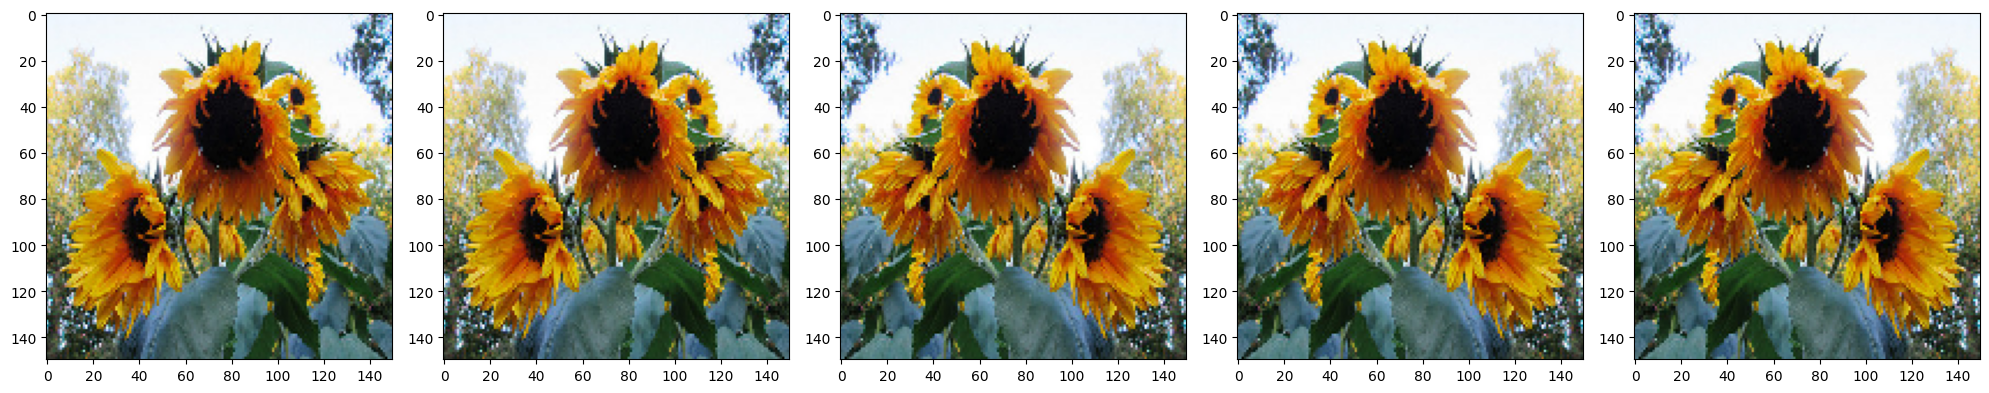

In [146]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()
  
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### TODO: примените произвольный переворот изображения

В ячейке ниже, воспользовавшись классом `ImageDataGenerator` сперва нормализуйте цветное изображение и примените произвольный поворот на 25 градусов. После этого воспользуйтесь методом .flow_from_directory для применения полученного преобразования к изображениям из обучающего набора данных. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [147]:
image_gen = ImageDataGenerator(
    rescale=1./255,              # Нормализация значений пикселей
    rotation_range=25,           # Произвольный поворот на 25 градусов
    horizontal_flip=True         # Произвольный горизонтальный переворот
)

train_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),      # Целевой размер изображений
    batch_size=100,              # Размер обучающего блока
    shuffle=True                 # Перемешивание изображений
)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наше преобразование:

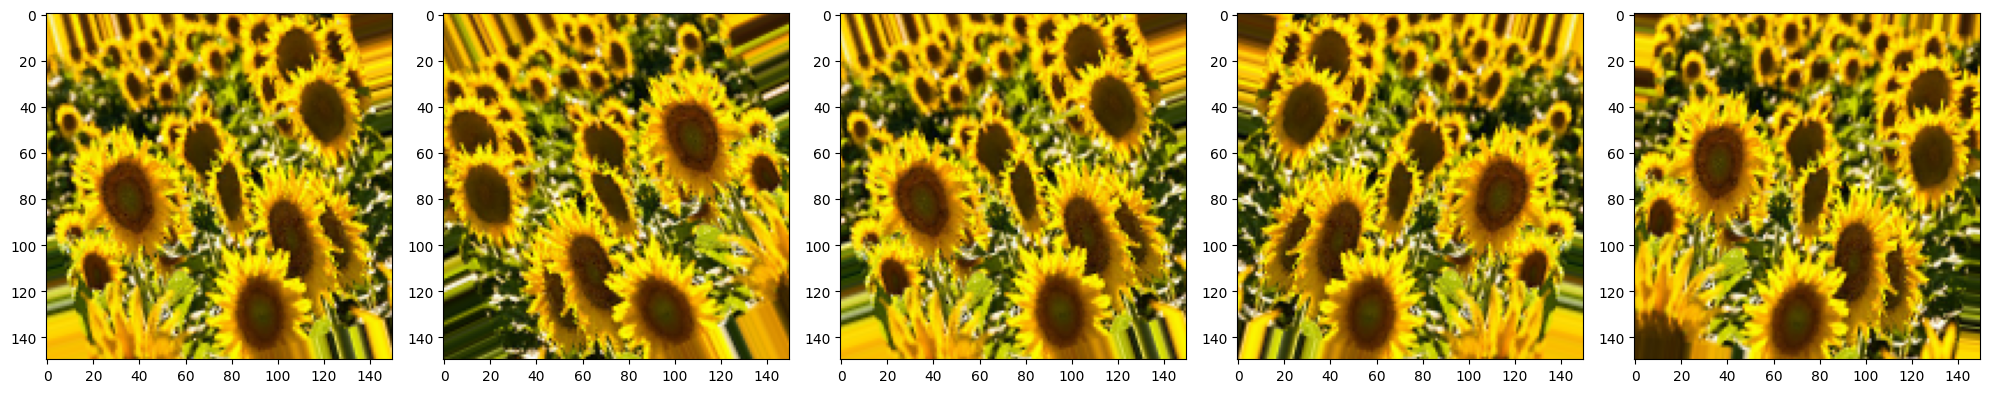

In [148]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### TODO: примените произвольное увеличение изображения

В ячейке ниже, воспользовавшись классом ImageDataGenerator сперва нормализуйте цветное изображение и примените произвольное увеличение до 30%. После этого воспользуйтесь методом .flow_from_directory для применения полученного преобразования к изображениям из обучающего набора данных. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [149]:
image_gen = ImageDataGenerator(
    rescale=1./255,              # Нормализация значений пикселей
    zoom_range=0.3,              # Произвольное увеличение до 30%
)


train_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),      # Целевой размер изображений
    batch_size=100,              # Размер обучающего блока
    shuffle=True                 # Перемешивание изображений
)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наше преобразование:

In [150]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

KeyboardInterrupt: 

#### TODO: объединяем все изменения

В ячейке ниже укажите код, который использует `ImageDataGenerator` для нормализации цветного изображения и выполняет следующие преобразования произвольным образом:

- поворот на 25 градусов
- увеличение до 30%
- горизонтальное отражение 
- смещение по ширине на 0.1
- смещение по высоте на 0.1

Затем воспользуйтесь методом `flow_from_directory` для применения перечисленных выше трансформаций к изображениям в обучающем наборе. Убедитесь, что указали корректно размер обучающего блока, путь к директории с обучающим набором данных, целевой размер изображений и не забудьте затем перемешать все изображения.

In [ ]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,              # Нормализация значений пикселей
    rotation_range=25,           # Поворот на 25 градусов
    zoom_range=0.3,              # Увеличение до 30%
    horizontal_flip=True,        # Горизонтальное отражение
    width_shift_range=0.1,       # Смещение по ширине на 0.1
    height_shift_range=0.1       # Смещение по высоте на 0.1
)

train_data_gen = image_gen_train.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),      # Целевой размер изображений
    batch_size=100,              # Размер обучающего блока
    shuffle=True,   # Перемешивание изображений
    class_mode='sparse'                
)

Found 2935 images belonging to 5 classes.


Давайте возьмём одно произвольное изображение и отобразим его 5 раз применив случайным образом наши преобразования:

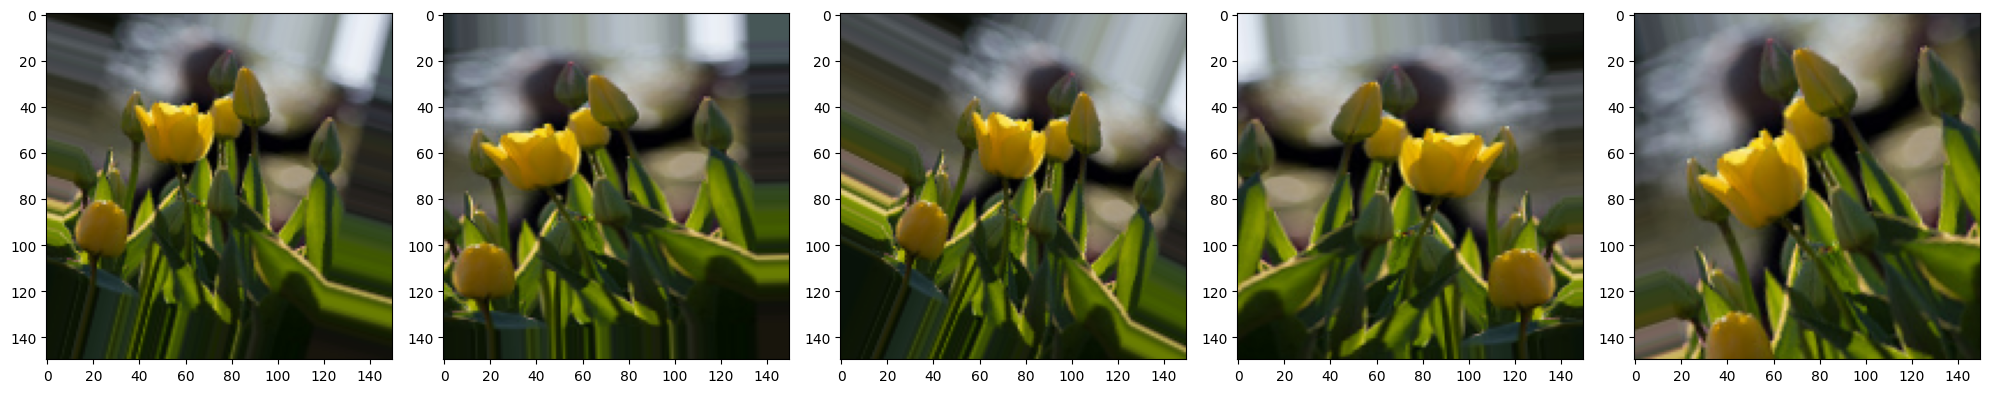

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### TODO: создайте генератор изображений для валидационного набора данных

В основном расширение данных применяется к обучающему набору данных. Поэтому, в ячейке ниже, воспользуйтесь классом `ImageDataGenerator` только для того, чтобы нормализовать значения пикселей цветного изображения. Затем воспользуйтесь методом `flow_from_directory` для применения указанной единственной трансформации к изображениям в валидационном наборе. Убедитесь, что указали корректно размер валидационного блока, путь к директории с валидационным набором данных и целевой размер изображений. Перемешивать валидационный набор данных не обязательно.

In [ ]:

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(
    val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse'
)

Found 735 images belonging to 5 classes.


# TODO: Создайте свёрточную нейронную сеть

В ячейке ниже создайте свёрточную нейронную сеть, которая будет состоять из 3 свёрточных пар - слой свёртки и слой подвыборки по максимальному значению. Первый свёрточный слой должен иметь 16 фильтров, второй - 32 фильтра, третий - 64 фильтра. Все фильтры должны быть размером 3х3. Размер окна подвыборки на всех слоях должен быть размером 3х3.

После всех трёх свёрточных пар должен идти слой `Flatten`, а затем полносвязный слой с 256 нейронами. Свёрточная нейронная сеть на выходе должна выдавать распределение вероятностей по 5 классам, чего можно добиться использованием функции активации **softmax**. Все остальные слои должны использовать функцию активации **relu**. Так же, где имеет смысл, добавьте слой отключения нейронов с вероятностью 20%.

In [ ]:
model = keras.Sequential([
    # Первая сверточная пара
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    layers.MaxPooling2D((3, 3)),
    
    # Вторая сверточная пара
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    
    # Третья сверточная пара
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    
    # Выравнивание в одномерный вектор
    layers.Flatten(),
    
    # Полносвязный слой
    layers.Dense(256, activation='relu'),
    
    # Слой отключения нейронов
    layers.Dropout(0.2),
    
    # Выходной слой
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)        

# TODO: скомпилируйте модель

В ячейке ниже напишите код, который будет компилировать модель с использованием оптимизатора `adam` и использовать `sparse_categorical_crossentropy` в качестве функции потерь. Так же мы хотим отслеживать метрику точности на обучающем наборе данных и валидационном наборе на каждой обучающей итерации, поэтому не забудьте передать соответствующий параметр в метод `compile(...)`.

In [ ]:
# компилирование модели

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TODO: обучите модель

В ячейке ниже напишите код, который запустит обучение модели с использованием функции **fit_generator** вместо обычной функции **fit**, которую мы ранее использовали. Мы используем функцию **fit_generator** потому что прибегаем к использованию класса **ImageDataGenerator** для генерации новых обучающих и валидационных данных для нашей модели. Обучите модель на 80 итерациях и убедитесь, что используете подходящие параметры в **fit_generator**-функции.

In [ ]:
epochs = 80

history = model.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

C:\Users\uumk0\AppData\Local\Temp\ipykernel_12832\1548548047.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
30/30 [==============================] - 78s 3s/step - loss: 1.5137 - accuracy: 0.3308 - val_loss: 1.2376 - val_accuracy: 0.5129
Epoch 2/10
30/30 [==============================] - 52s 2s/step - loss: 1.2025 - accuracy: 0.4746 - val_loss: 1.0969 - val_accuracy: 0.5565
Epoch 3/10
30/30 [==============================] - 52s 2s/step - loss: 1.0857 - accuracy: 0.5465 - val_loss: 1.0481 - val_accuracy: 0.5810
Epoch 4/10
30/30 [==============================] - 47s 2s/step - loss: 1.0604 - accuracy: 0.5714 - val_loss: 0.9486 - val_accuracy: 0.6231
Epoch 5/10
30/30 [==============================] - 37s 1s/step - loss: 0.9858 - accuracy: 0.6037 - val_loss: 0.8705 - val_accuracy: 0.6558
Epoch 6/10
30/30 [==============================] - 47s 2s/step - loss: 0.9366 - accuracy: 0.6344 - val_loss: 0.8586 - val_accuracy: 0.6585
Epoch 7/10
30/30 [==============================] - 35s 1s/step - loss: 0.9106 - accuracy: 0.6429 - val_loss: 0.8350 - val_accuracy: 0.6776
Epoch 8/10
30/30 [==

# TODO: постройте графики точности / потерь для обучающего и валидационного наборов данных

В ячейке ниже напишите код, который построит графики точности и потерь для обучающего и валидационного наборов данных:

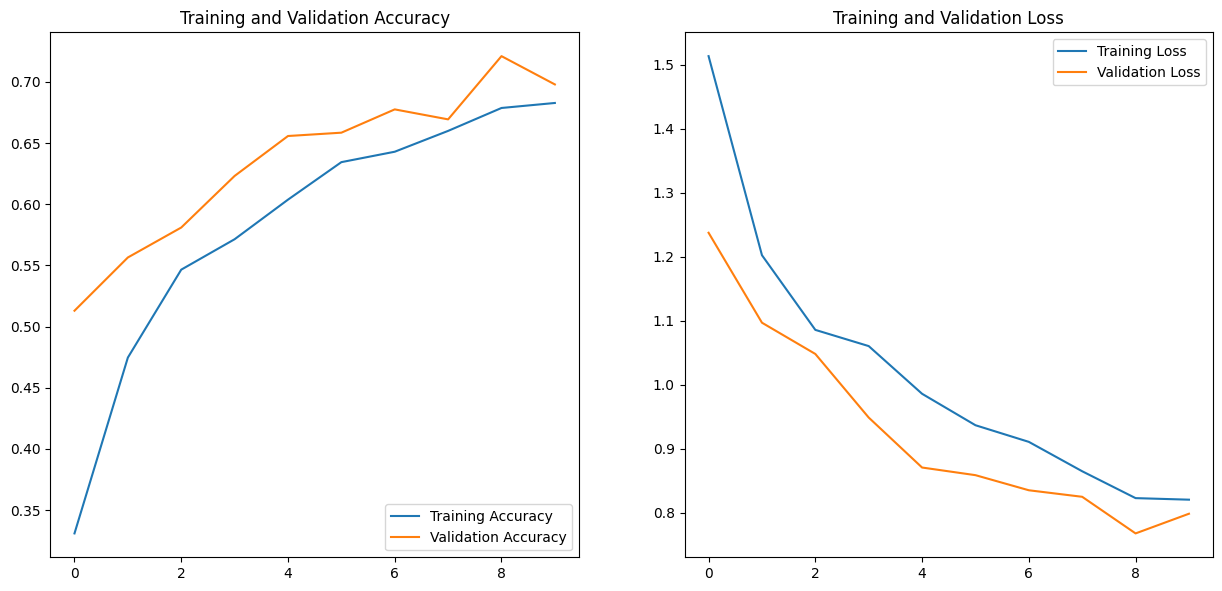

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Создайте альтернативную сверточную сеть

Дойдя до этого момента вы создали свёрточную нейронную сеть с тремя свёрточными блоками (слой свёртки + слой подвыборки) и последующим полносвязным слоем состоящим из 256 нейронов. В ячейке ниже напишите код для создания новой свёрточной сети с другой архитектурой.
В зависимости от варианта сделайте одно из изменений:


1.   Уменьшите размеры входного изображения примерно на 30%, исключите первый слой подвыборки.
2.   Уменьшите размеры входного изображения примерно на 30%, исключите второй слой подвыборки.
3.   Уменьшите размеры входного изображения примерно на 30%, исключите третий слой подвыборки.
4.   Добавьте четвертый слой свертки и подвыборки.


In [ ]:
model_alt = keras.Sequential([
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(5, activation='softmax'),
])
model.summary()

model_alt.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

epochs = 80

history_alt = model_alt.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)        

C:\Users\uumk0\AppData\Local\Temp\ipykernel_12832\2018230910.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_alt = model_alt.fit_generator(


Epoch 1/10
30/30 [==============================] - 34s 1s/step - loss: 1.6084 - accuracy: 0.2426 - val_loss: 1.6073 - val_accuracy: 0.2449
Epoch 2/10
30/30 [==============================] - 34s 1s/step - loss: 1.6065 - accuracy: 0.2446 - val_loss: 1.6058 - val_accuracy: 0.2449
Epoch 3/10
30/30 [==============================] - 31s 1s/step - loss: 1.6051 - accuracy: 0.2446 - val_loss: 1.6045 - val_accuracy: 0.2449
Epoch 4/10
30/30 [==============================] - 50s 2s/step - loss: 1.6040 - accuracy: 0.2446 - val_loss: 1.6034 - val_accuracy: 0.2449
Epoch 5/10
30/30 [==============================] - 39s 1s/step - loss: 1.6031 - accuracy: 0.2446 - val_loss: 1.6026 - val_accuracy: 0.2449
Epoch 6/10
30/30 [==============================] - 34s 1s/step - loss: 1.6024 - accuracy: 0.2446 - val_loss: 1.6020 - val_accuracy: 0.2449
Epoch 7/10
30/30 [==============================] - 34s 1s/step - loss: 1.6018 - accuracy: 0.2446 - val_loss: 1.6016 - val_accuracy: 0.2449
Epoch 8/10
30/30 [==

Отобразите графики точности и потерь для новой версии сети.

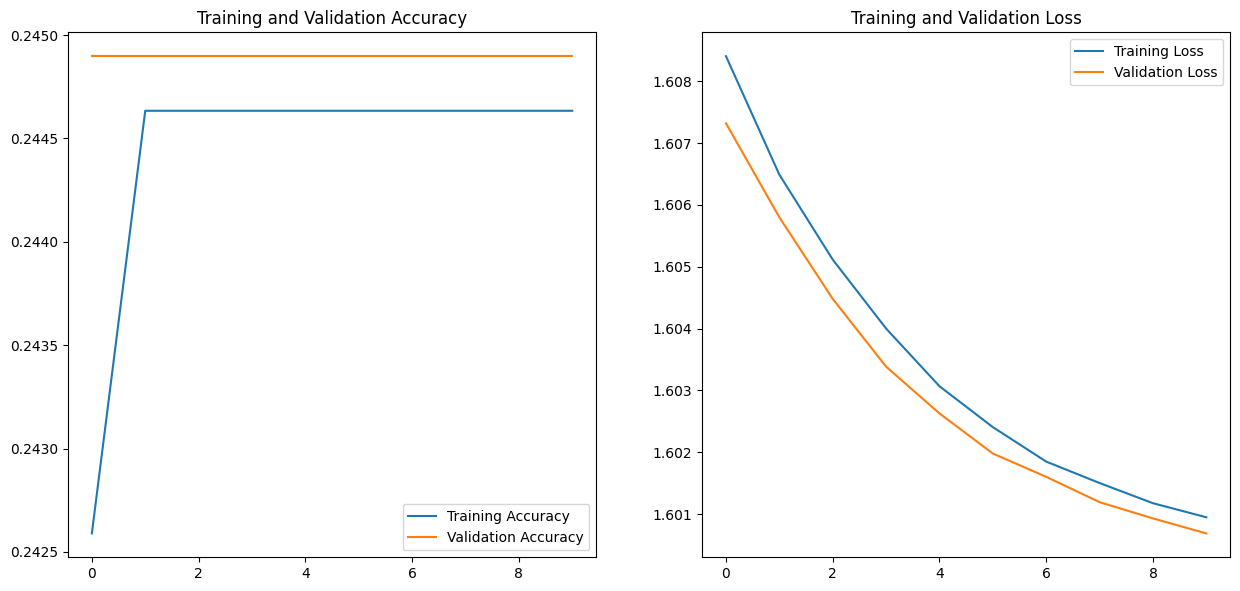

In [ ]:
acc_alt = history_alt.history['accuracy']
val_acc_alt = history_alt.history['val_accuracy']
loss_alt = history_alt.history['loss']
val_loss_alt = history_alt.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc_alt, label='Training Accuracy')
plt.plot(epochs_range, val_acc_alt, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss_alt, label='Training Loss')
plt.plot(epochs_range, val_loss_alt, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


Напишите ниже выводы о качестве полученной сети по сравнению с первой:
1. Размеры входного изображения уменьшены примерно на 30% во второй сети. Это может привести к потере некоторой информации и деталей изображения, что может сказаться на качестве предсказаний.

2. Во второй сети исключен один из слоев подвыборки. Это может привести к уменьшению способности сети к обобщению и устойчивости к вариациям в данных.

3. Добавлен четвертый слой свертки и подвыборки во второй сети. Это может помочь сети извлекать более высокоуровневые признаки из изображений, что может привести к улучшению качества предсказаний.

4. Графики точности и потерь для новой версии сети могут отличаются от первой сети координально.

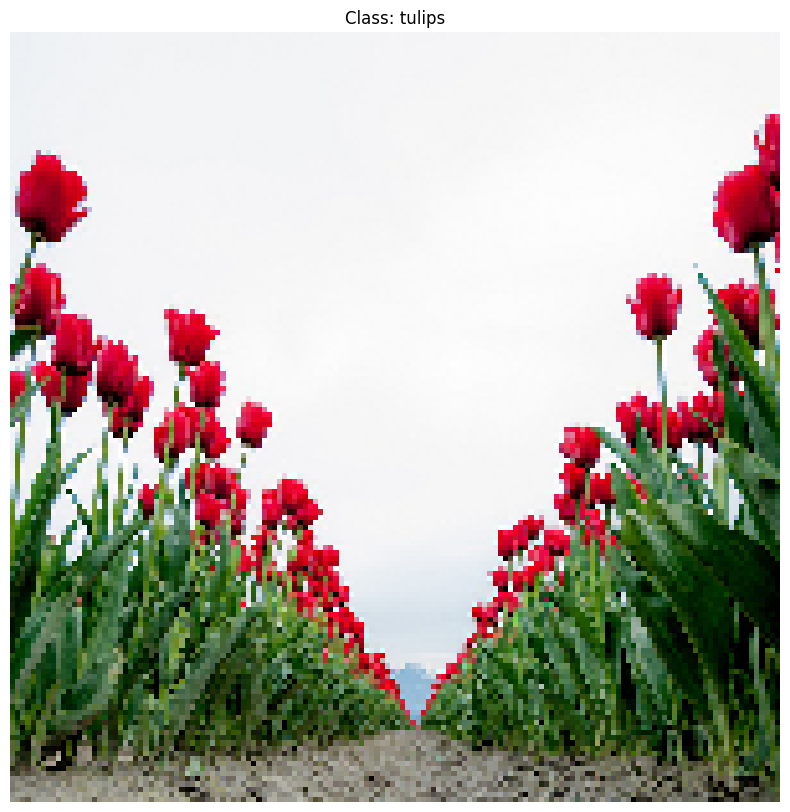

1/1 [==============================] - 0s 34ms/step


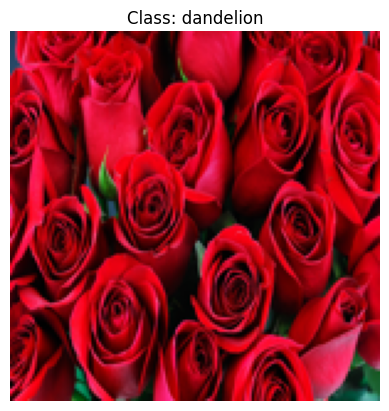

In [ ]:
from PIL import Image

image_path = r"C:\Users\uumk0\Downloads\Foto-rozy_00164-scaled.jpg"  # Замените на путь, по которому вы хотите сохранить изображение

# Загрузка и предобработка изображений из датасета
sample_images = []
sample_labels = []
num_samples = 1

for i in range(num_samples):
    image, label = next(val_data_gen)
    sample_images.append(image[0])
    sample_labels.append(label[0])

# Визуализация изображений и их классификация
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {classes[int(sample_labels[i])]}")
    plt.axis("off")

plt.show()

# Классификация изображений из Интернета
custom_image = Image.open(image_path).resize((IMG_SHAPE, IMG_SHAPE))
custom_image = np.array(custom_image) / 255.0
custom_image = np.expand_dims(custom_image, axis=0)

predictions = model.predict(custom_image)
class_index = np.argmax(predictions[0])
class_label = classes[class_index]

plt.imshow(custom_image[0])
plt.title(f"Class: {class_label}")
plt.axis("off")
plt.show()


In [ ]:
from PIL import Image

image_path = r"C:\Users\uumk0\Downloads\Foto-rozy_00164-scaled.jpg"  # Замените на путь, по которому вы хотите сохранить изображение

# Загрузка и предобработка изображений из датасета
sample_images = []
sample_labels = []
num_samples = 1

for i in range(num_samples):
    image, label = next(val_data_gen)
    sample_images.append(image[0])
    sample_labels.append(label[0])

# Визуализация изображений и их классификация
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {classes[int(sample_labels[i])]}")
    plt.axis("off")

plt.show()

custom_image = Image.open(image_path).resize((IMG_SHAPE, IMG_SHAPE))
custom_image = np.array(custom_image) / 255.0
custom_image = np.expand_dims(custom_image, axis=0)

predictions = model.predict(custom_image)
class_index = np.argmax(predictions[0])
class_label = classes[class_index]

predictions_alt = model_alt.predict(custom_image)
class_index_alt = np.argmax(predictions_alt[0])
class_label_alt = classes[class_index_alt]

plt.imshow(custom_image[0])
plt.title(f"Class: {class_label}")
plt.axis("off")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\uumk0\\.keras\\datasets\\flower_photos\\val\\tulips\\8619064872_dea79a9eb9.jpg'